# NLP Project: Pokemon Type Predictor
## Author: Brady Lamson
## Date: Fall 2023

# Data Loading

Here we connect to kaggle and download the dataset. Note that an access token is required to run this code. 
This file also has some wack encoding, so I have to modify that to read in the file.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.style

In [2]:
!kaggle datasets download -d cristobalmitchell/pokedex
data_path = "./data/pokemon.csv"
if not os.path.isfile(data_path):
    !unzip pokedex.zip -d data

df = pd.read_csv(data_path, sep='\t', encoding='utf-16-le')
df.head()

pokedex.zip: Skipping, found more recently modified local copy (use --force to force download)


,national_number,gen,english_name,japanese_name,primary_type,secondary_type,classification,percent_male,percent_female,height_m,...,evochain_1,evochain_2,evochain_3,evochain_4,evochain_5,evochain_6,gigantamax,mega_evolution,mega_evolution_alt,description
0,1,I,Bulbasaur,Fushigidane,grass,poison,Seed Pokémon,88.14,11.86,0.7,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,There is a plant seed on its back right from t...
1,2,I,Ivysaur,Fushigisou,grass,poison,Seed Pokémon,88.14,11.86,1.0,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,NaN,NaN,NaN,"When the bulb on its back grows large, it appe..."
2,3,I,Venusaur,Fushigibana,grass,poison,Seed Pokémon,88.14,11.86,2.0,...,Level,Ivysaur,Level,Venusaur,NaN,NaN,Gigantamax Venusaur,Mega Venusaur,NaN,Its plant blooms when it is absorbing solar en...
3,4,I,Charmander,Hitokage,fire,NaN,Lizard Pokémon,88.14,11.86,0.6,...,Level,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,It has a preference for hot things. When it ra...
4,5,I,Charmeleon,Lizardo,fire,NaN,Flame Pokémon,88.14,11.86,1.1,...,Level,Charmeleon,Level,Charizard,NaN,NaN,NaN,NaN,NaN,"It has a barbaric nature. In battle, it whips ..."


# Data Exploration

I always like to take a look at what we can expect from a single row. It seems this dataset contains a TON of information.

In [3]:
df.iloc[0]

national_number                                                       1
gen                                                                   I
english_name                                                  Bulbasaur
japanese_name                                               Fushigidane
primary_type                                                      grass
secondary_type                                                   poison
classification                                             Seed Pokémon
percent_male                                                      88.14
percent_female                                                    11.86
height_m                                                            0.7
weight_kg                                                           6.9
capture_rate                                                         45
base_egg_steps                                                     5120
hp                                                              

## Removing unnecessary columns

Seems we can par this down a lot and remove a ton of the columns. We only really care about a few of them, like `english_name`, `primary_type`, `secondary_type` and `description`. 

In [12]:
columns_to_keep = ['english_name', 'primary_type', 'secondary_type', 'description']
df = df[columns_to_keep]
df.head()

,english_name,primary_type,secondary_type,description
0,Bulbasaur,grass,poison,There is a plant seed on its back right from t...
1,Ivysaur,grass,poison,"When the bulb on its back grows large, it appe..."
2,Venusaur,grass,poison,Its plant blooms when it is absorbing solar en...
3,Charmander,fire,NaN,It has a preference for hot things. When it ra...
4,Charmeleon,fire,NaN,"It has a barbaric nature. In battle, it whips ..."


## Checking Types and Frequency

In [5]:
num_types = len(df.primary_type.unique())
y_axis = np.arange(num_types)
primary_counts = (
    df
    .primary_type
    .value_counts()
    .rename("primary_counts")
)
secondary_counts = (
    df
    .secondary_type
    .value_counts()
    .rename("secondary_counts")
)
count_df = (
    pd.concat([primary_counts, secondary_counts], axis=1)
    .reset_index(names="type")
)
count_df

,type,primary_counts,secondary_counts
0,water,123,18
1,normal,109,6
2,grass,86,22
3,bug,75,9
4,fire,58,16
5,psychic,58,35
6,rock,50,15
7,electric,49,9
8,dark,36,25
9,fighting,36,26


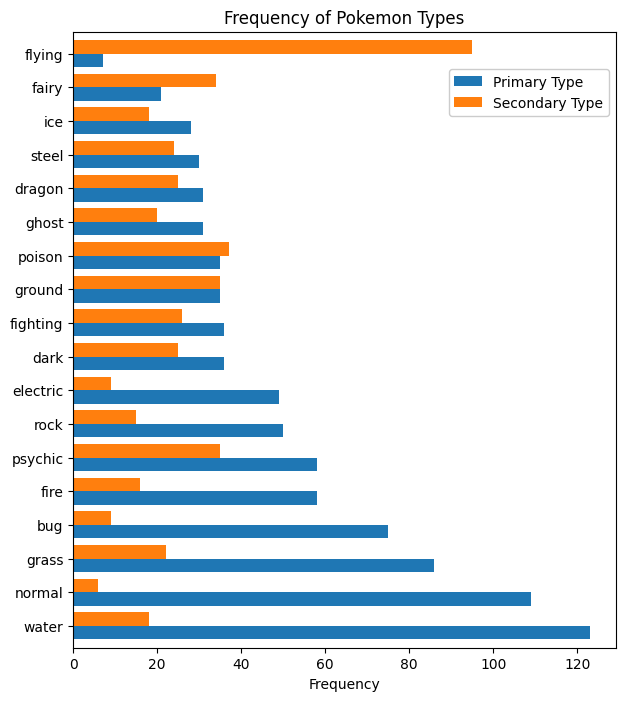

In [29]:
matplotlib.style.use("default")
ax = (
    count_df
    .plot
    .barh(
        x='type',
        figsize=(7,8),
        title="Frequency of Pokemon Types",
        xlabel="Frequency",
        ylabel="",
        # grid=True,
        width=0.8
    )
    .legend(
        ['Primary Type', 'Secondary Type'],
        loc="upper right",
        bbox_to_anchor=(1,0.95),
        fancybox=True, 
        framealpha=1,
        ncol=1
    )
)

### Thoughts

This data is very strangely unbalanced. I knew that going in but this is extreme. Some types basically only exist as primary or secondary which is super interesting. These two columns are unbalanced in almost opposite ways. This will be very interesting to work around.

## Description Length Analysis

Next up is how long are the pokemon descriptions? This is a particularly interesting question because it depends on the "generation" of games we pull this info from. Each new set of pokemon games comes with its own unique set of pokedex entries for pokemon, and they tended to get longer as the consoles they were on became more powerful. Regardless, let's see how long these are.

### Character Count Length

Text(170, 205, '$\\mu = 122.83, \\sigma = 26.23$')

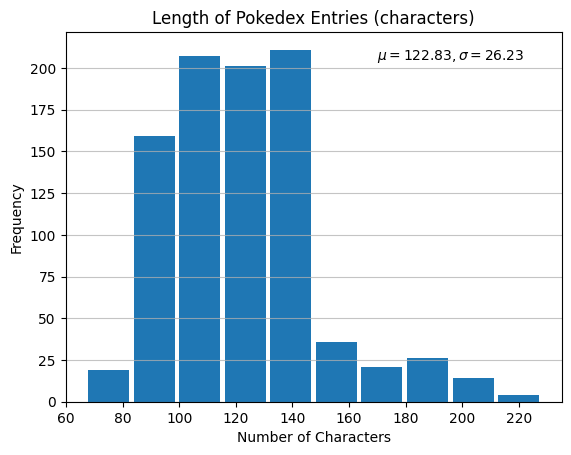

In [66]:
df = (
    df.assign(
        entry_length = df.description.apply(len)
    )
)
mean = round(df.entry_length.mean(), 2)
sd = round(df.entry_length.std(), 2)

df.entry_length.hist(rwidth=0.9, grid=False)
plt.title("Length of Pokedex Entries (characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.text(170,205, f"$\mu = {mean}, \sigma = {sd}$")

Some more information

In [53]:
df.entry_length.describe()

count    898.000000
mean     122.825167
std       26.228257
min       67.000000
25%      102.000000
50%      121.000000
75%      137.000000
max      228.000000
Name: entry_length, dtype: float64

Much like the plot hints, this data is mostly gathered around the 100-140 character length range. That's good to know.

### Token Count

Text(30, 275, '$\\mu = 21.77, \\sigma = 4.79$')

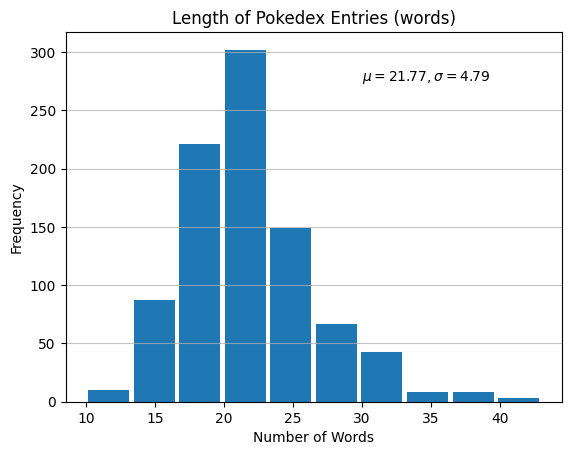

In [65]:
df = (
    df.
    assign(
        word_count=df['description'].str.split().apply(len)
    )
)

mean = round(df.word_count.mean(), 2)
sd = round(df.word_count.std(), 2)

df.word_count.hist(rwidth=0.9, grid=False)
plt.title("Length of Pokedex Entries (words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.text(30,275, f"$\mu = {mean}, \sigma = {sd}$")

In [67]:
df.word_count.describe()

count    898.000000
mean      21.772829
std        4.787532
min       10.000000
25%       18.000000
50%       21.000000
75%       24.000000
max       43.000000
Name: word_count, dtype: float64

What we see is a close to normal or log-normal distribution of word length. That's neat. Not too sure if that's important, but it is cool! 

Overall though these values will help us later when we choose to pad or truncate any sequences during the tokenization step.